## Part 1. Overview

In this notebook, an exploratory data analysis will be performed on the NYC trip and weather data which was preprocessed in notebook #1. 

1. Take a closer look on each feature by plotting their distributions. 
2. Identify correlations between features by using a correlation heat map and scatter plots
3. Answer some EDA questions:
    - What days of the week and times of the day are ride-hailing services usually high in demand?
    

We might also do more data preprocessing steps depending on need, like standardization, handling of categorical variables, and handling multicollinearity. 

## Part 2. Setup

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
import numpy as np
import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore")
sns.set_style(style='whitegrid')

## Part 3. Improvements

1. Remove "ignore warnings"?
2. Add weekend flag to trend visualization

## Part 4. Analysis

Let's first load the data and display some summary statistics of the numerical variables.

In [2]:
working_df = pd.read_csv('../data/nyc_trip_weather_data.csv',index_col=0)
working_df['datetime'] = pd.to_datetime(working_df['datetime'])
working_df.describe()

,datetime,trip_count,tempm,dewptm,hum,wspdm,wdird,vism,pressurem,fog,rain,snow,hail,thunder,tornado,hr,day_of_wk,weekend,month
count,8400,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.0,8400.0,8400.0,8400.000000,8400.000000,8400.000000,8400.000000
mean,2016-07-02 09:04:23.142857216,15040.559286,13.710083,5.015964,58.546905,8.614714,84.723810,14.473964,1016.720399,0.003571,0.044048,0.009048,0.0,0.0,0.0,11.513095,3.007500,0.286667,6.525714
min,2016-01-01 00:00:00,97.000000,-18.300000,-28.300000,9.000000,0.000000,0.000000,0.400000,989.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000
25%,2016-03-30 18:45:00,10395.750000,6.100000,-3.300000,45.000000,5.600000,0.000000,14.500000,1011.900000,0.000000,0.000000,0.000000,0.0,0.0,0.0,5.750000,1.000000,0.000000,3.000000
50%,2016-07-02 16:30:00,15571.500000,13.300000,5.600000,57.000000,7.400000,0.000000,16.100000,1016.900000,0.000000,0.000000,0.000000,0.0,0.0,0.0,12.000000,3.000000,0.000000,7.000000
75%,2016-10-03 22:15:00,19467.500000,22.200000,13.900000,73.000000,11.100000,180.000000,16.100000,1021.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,18.000000,5.000000,1.000000,10.000000
max,2016-12-31 23:00:00,41664.000000,35.600000,25.600000,100.000000,137.000000,360.000000,16.100000,1040.900000,1.000000,1.000000,1.000000,0.0,0.0,0.0,23.000000,6.000000,1.000000,12.000000
std,NaN,6538.168279,9.748369,10.818121,18.524632,6.204748,119.288361,3.180446,7.437588,0.059658,0.205213,0.094693,0.0,0.0,0.0,6.925406,1.993277,0.452231,3.481115


### Univariate Distributions

Let's visualize the distributions of the numerical variables:

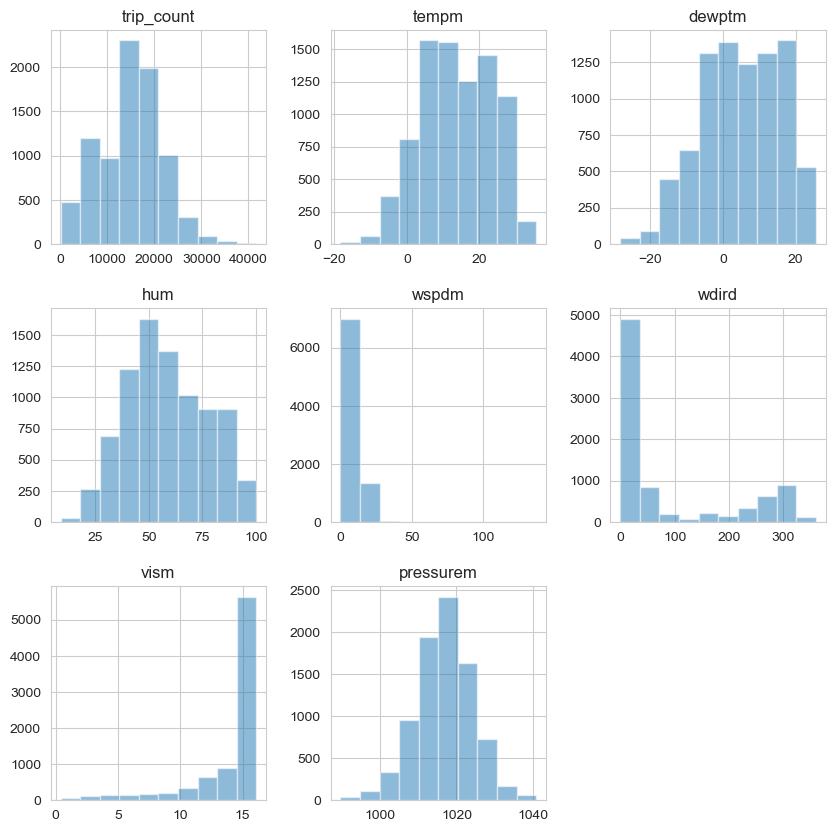

In [3]:
num_vars = ['trip_count', 'tempm', 'dewptm', 'hum',
            'wspdm', 'wdird','vism', 'pressurem']
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
working_df[num_vars].hist(alpha=0.5, ax=ax)
plt.show()

It looks like some of the numerical variables are approximately normally distributed, except for windspeed, wind direction, and visibility which are heavily right/left skewed. In addition, looking at wind speed, the maximum value is 137 kmph. A quick Google search suggested that wind speeds in the range of 118-134 kmph signify a hurricane. We can look at the date-times with the strongest wind speed to rule out data discrepancy.

,datetime,wspdm
5941,2016-09-04 13:00:00,137.0
2558,2016-04-16 14:00:00,120.4
2111,2016-03-28 23:00:00,40.7
2112,2016-03-29 00:00:00,37.0
537,2016-01-23 09:00:00,37.0


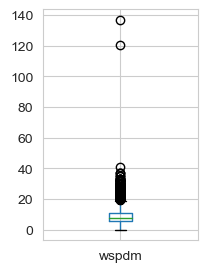

In [4]:
display(working_df[['datetime','wspdm']].sort_values(by='wspdm', ascending=False).head())
working_df[['wspdm']].boxplot(figsize=(2,3))
plt.show()

Two dates with high wind speeds stand out and appear to be outliers. Let's visualize the hourly wind speed on September 4, 2016 and April 4, 2016.

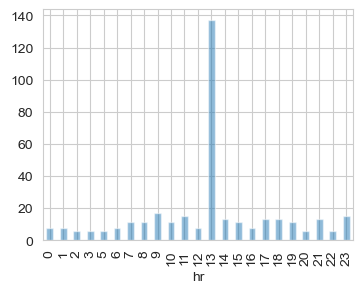

In [5]:
dt_hi_wspd = working_df[working_df['wspdm']==137]['datetime'].dt.date.values[0]
eda = working_df[working_df['datetime'].dt.date == dt_hi_wspd][['hr','wspdm']].set_index('hr')
eda['wspdm'].plot(kind='bar',alpha=0.5,figsize=(4,3))
plt.show()

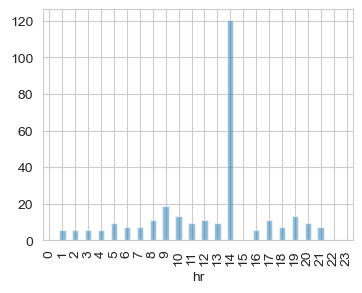

In [6]:
dt_hi_wspd = working_df[working_df['wspdm']==120.4]['datetime'].dt.date.values[0]
eda = working_df[working_df['datetime'].dt.date == dt_hi_wspd][['hr','wspdm']].set_index('hr')
fig = plt.figure(figsize = (4,3))
ax = fig.gca()
eda['wspdm'].plot(kind='bar',alpha=0.5)
plt.show()

From these plots, we can confirm that these two data points are outliers since it doesn't seem reasonable for a hurricane to only last an hour. We can replace these two data points with the mean wind speed before and after, similar to the imputation method we did in notebook #1.

In [7]:
# if windspeed > 120, replace with NaN
# fillna with mean of values before and after

working_df['wspdm'] = working_df['wspdm'].apply(lambda x: np.nan if x > 120 else x)
working_df['wspdm'] = working_df['wspdm'].fillna((working_df['wspdm'].shift()+working_df['wspdm'].shift(-1))/2)

Let's now look at the distributions of the categorical variables:

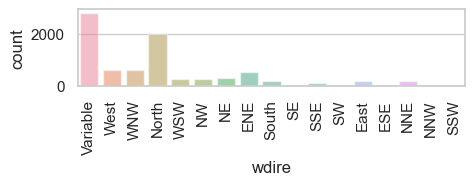

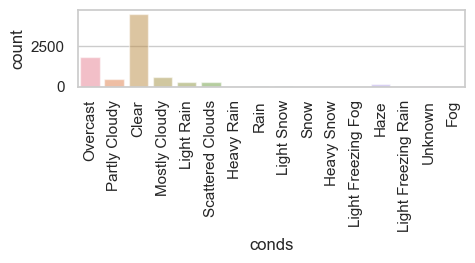

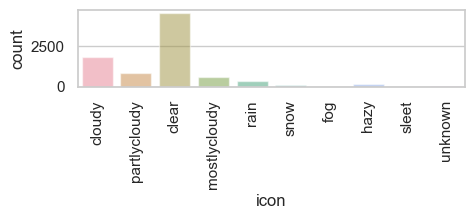

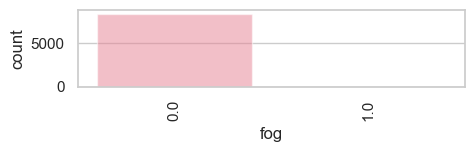

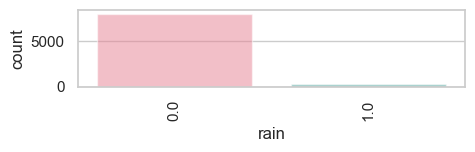

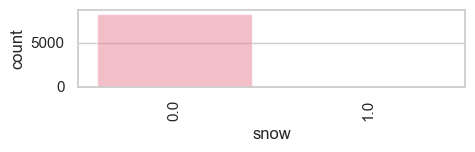

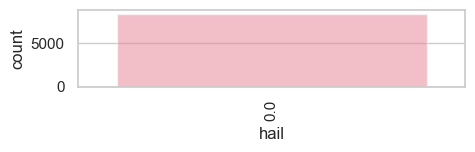

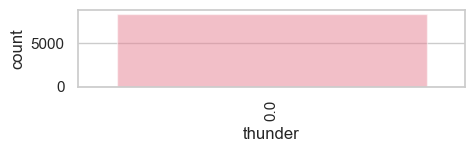

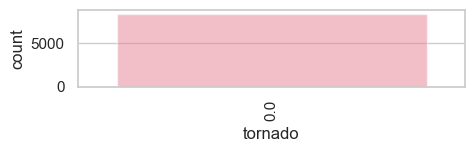

In [8]:
cat_vars = ['wdire','conds', 'icon', 'fog', 'rain', 'snow',
            'hail', 'thunder', 'tornado']
sns.set(style='whitegrid',rc={'figure.figsize':(5,1)})
for i in cat_vars:    
    plot = sns.countplot(working_df, x=i, palette="husl",alpha=0.5)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plt.show()


Three variables, hail, thunder, and tornado will be removed from the feature set since all values are zero and it won't give us any information. Two variables, conds and icon, appear to have similar values, with conds having more detailed weather descriptions. For example, "rain" in icon is further divided into "light rain", "heavy rain", "rain" in conds. So we will drop the column icon in favor of conds. Since we're going to use one-hot encoding to transform the "string" categorical variables, it is important to drop redundant columns to avoid an increase in dimensionality.

Moreover, since information on fog, rain and snow is already available in the conds column, we will also remove these three variable.

In [9]:
remove_cols = ['hail','thunder','tornado','icon','fog','rain','snow']
working_df = working_df.drop(columns=remove_cols)

### Feature Engineering of Categorical Variables

We will transform the features wdire and conds using one-hot encoding. One hot encoding is a technique that is used to represent categorical variables as numerical values. For example, if a categorical variable has two values or categories, the one-hot encoding will transform it into two new columns. 

In [10]:
print(f"Size before OHE: {working_df.shape}")
working_df = pd.get_dummies(working_df, columns=['wdire','conds'], dtype='int')
print(f"Size after OHE: {working_df.shape}")
working_df.head()

Size before OHE: (8400, 15)
Size after OHE: (8400, 46)


,datetime,trip_count,tempm,dewptm,hum,wspdm,wdird,vism,pressurem,hr,...,conds_Light Freezing Rain,conds_Light Rain,conds_Light Snow,conds_Mostly Cloudy,conds_Overcast,conds_Partly Cloudy,conds_Rain,conds_Scattered Clouds,conds_Snow,conds_Unknown
0,2016-01-01 00:00:00,19631,5.6,-3.9,51.0,7.4,0.0,16.1,1017.9,0,...,0,0,0,0,1,0,0,0,0,0
1,2016-01-01 01:00:00,23665,5.0,-3.9,53.0,5.6,0.0,16.1,1017.8,1,...,0,0,0,0,1,0,0,0,0,0
2,2016-01-01 02:00:00,23476,5.0,-3.3,55.0,7.4,280.0,16.1,1017.7,2,...,0,0,0,0,1,0,0,0,0,0
3,2016-01-01 03:00:00,20836,5.0,-3.3,55.0,14.8,280.0,16.1,1017.7,3,...,0,0,0,0,1,0,0,0,0,0
4,2016-01-01 04:00:00,15085,4.4,-3.3,58.0,16.7,270.0,16.1,1017.0,4,...,0,0,0,0,1,0,0,0,0,0


### Correlations

Before proceeding with more in-depth explorations, let's first check the correlation between the variables to give us a roadmap on how to proceed further.

In [11]:
corr = working_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,datetime,trip_count,tempm,dewptm,hum,wspdm,wdird,vism,pressurem,hr,day_of_wk,weekend,month,wdire_ENE,wdire_ESE,wdire_East,wdire_NE,wdire_NNE,wdire_NNW,wdire_NW,wdire_North,wdire_SE,wdire_SSE,wdire_SSW,wdire_SW,wdire_South,wdire_Variable,wdire_WNW,wdire_WSW,wdire_West,conds_Clear,conds_Fog,conds_Haze,conds_Heavy Rain,conds_Heavy Snow,conds_Light Freezing Fog,conds_Light Freezing Rain,conds_Light Rain,conds_Light Snow,conds_Mostly Cloudy,conds_Overcast,conds_Partly Cloudy,conds_Rain,conds_Scattered Clouds,conds_Snow,conds_Unknown
datetime,1.000000,0.290965,0.133067,0.147635,0.073429,-0.115758,-0.007281,0.012710,0.094253,0.003235,0.003271,0.002353,0.996530,-0.072956,0.002020,-0.025452,-0.044440,-0.042848,0.009811,-0.032524,0.030718,-0.016432,-0.016196,0.012041,-0.009553,-0.017481,0.041962,0.029203,0.001454,0.023108,0.019989,0.017291,0.000873,0.014077,-0.036856,-0.016459,0.011737,-0.002226,-0.031234,0.003078,-0.053851,0.024577,0.029050,0.010156,-0.065195,0.081377
trip_count,0.290965,1.000000,0.101335,0.033130,-0.111795,0.023806,-0.004599,-0.013035,0.028610,0.620837,0.112624,0.050191,0.290045,-0.037427,-0.000376,0.007639,-0.054737,-0.031062,-0.005263,0.025209,-0.003621,-0.002086,0.026104,0.030504,0.004990,0.046404,0.037098,-0.006420,-0.020095,-0.016638,-0.005514,-0.000059,0.019562,0.026621,-0.052146,-0.024766,-0.002632,0.009567,-0.044460,0.008663,-0.014930,0.012189,0.026600,0.009988,-0.051928,0.016402
tempm,0.133067,0.101335,1.000000,0.890177,0.111293,-0.304932,-0.225932,-0.104371,-0.184244,0.100369,-0.025023,-0.014924,0.126957,-0.038897,0.001102,-0.016091,-0.045594,-0.050964,-0.001065,-0.138775,0.113833,0.006404,0.022269,0.004834,0.016077,0.032884,0.119008,-0.167106,0.015304,-0.079982,0.019639,-0.008519,0.070649,0.006918,-0.042687,-0.019041,-0.026908,-0.020135,-0.112895,0.062370,-0.131359,0.069502,-0.007571,0.073807,-0.087978,0.073441
dewptm,0.147635,0.033130,0.890177,1.000000,0.542880,-0.321505,-0.256232,-0.321489,-0.255638,-0.002087,-0.003385,0.008191,0.141971,0.003731,0.017788,0.031472,-0.018324,-0.040365,-0.020090,-0.170749,0.126800,0.015108,0.032241,0.006698,0.002971,0.037659,0.086082,-0.190022,0.005756,-0.088057,-0.158723,0.001093,0.110621,0.040189,-0.023634,-0.010708,-0.011036,0.088218,-0.063447,0.066547,0.015842,0.040719,0.050566,0.063819,-0.047948,0.044579
hum,0.073429,-0.111795,0.111293,0.542880,1.000000,-0.137193,-0.155818,-0.587058,-0.234589,-0.182275,0.034316,0.047910,0.072373,0.094299,0.037862,0.110896,0.051929,0.007615,-0.035058,-0.120122,0.069178,0.022299,0.027905,0.005452,-0.021692,0.023882,-0.033696,-0.119627,-0.021970,-0.055615,-0.408300,0.024419,0.110906,0.089125,0.035379,0.014994,0.034476,0.268397,0.086179,0.020679,0.292644,-0.047392,0.151197,-0.005103,0.074460,-0.041571
wspdm,-0.115758,0.023806,-0.304932,-0.321505,-0.137193,1.000000,0.481327,0.030321,-0.152116,0.042777,-0.029894,0.004867,-0.115177,0.226633,0.030667,0.105983,0.118276,0.080500,0.019564,0.187320,-0.574495,0.016800,0.030723,0.012410,0.036575,0.084956,-0.085220,0.241285,0.094737,0.156425,-0.122331,0.004634,-0.034982,0.006180,0.073026,0.018274,0.008134,0.022671,0.034904,0.009200,0.103007,0.019679,-0.002973,0.002094,0.110765,0.016452
wdird,-0.007281,-0.004599,-0.225932,-0.256232,-0.155818,0.481327,1.000000,0.117981,-0.117812,-0.004665,-0.033588,-0.032808,-0.007678,-0.043723,0.017418,0.000519,-0.064386,-0.072216,0.139939,0.348904,-0.323449,0.027960,0.070401,0.068647,0.102342,0.123236,-0.503998,0.498307,0.257080,0.443891,0.021848,0.007801,-0.027502,-0.015173,0.003944,-0.005921,0.000836,-0.037153,-0.012271,0.012782,-0.018166,0.025517,-0.015329,-0.005170,-0.021174,0.031970
vism,0.012710,-0.013035,-0.104371,-0.321489,-0.587058,0.030321,0.117981,1.000000,0.216552,0.037859,-0.035675,-0.048137,0.014537,-0.081931,-0.018924,-0.085006,-0.057198,-0.005137,0.028582,0.079714,-0.039452,-0.030489,-0.013406,-0.005883,0.016187,-0.046330,0.022584,0.087959,0.036615,0.059989,0.350981,-0.048288,-0.249548,-0.199360,-0.108001,-0.046916,-0.068591,-0.396097,-0.271873,0.0389

The predictor variables with relatively strong to moderate positive correlations to trip count is hour of the day (r = 0.62) and month of the year (r = 0.29). While temperature (r = 0.10), humidity (r = -0.11), day of the weak (r = 0.11) have week positive/negative correlations to trip count. Interestingly, the rain variables seem to have very weak correlations with the outcome variable. Using these insights, we will dive deeper into the data.

### Questions on Ride-Hailing Demand

#### 1. What does ride-hailing demand look like at different times of the day?

Do a time series plot looping over all dates, with different colors per month.

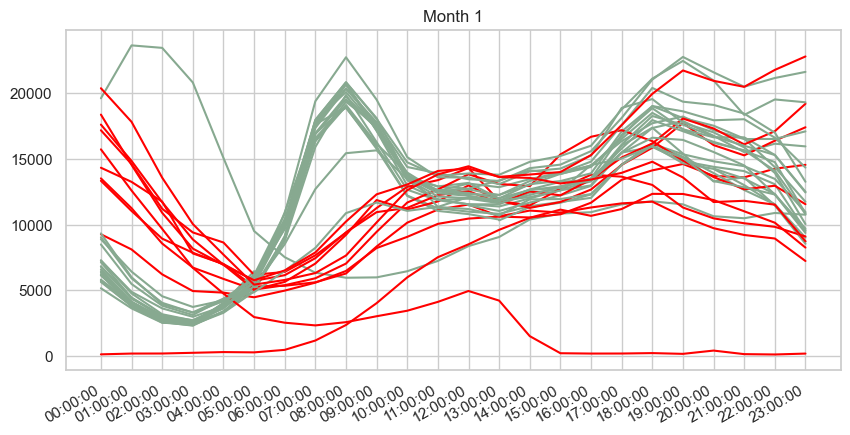

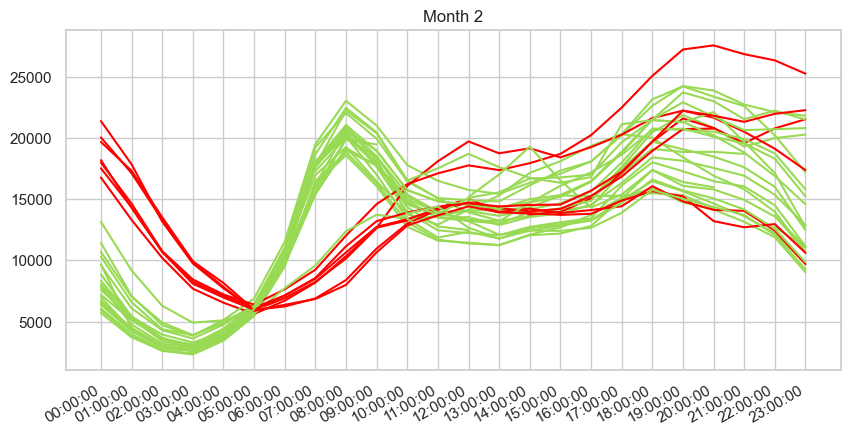

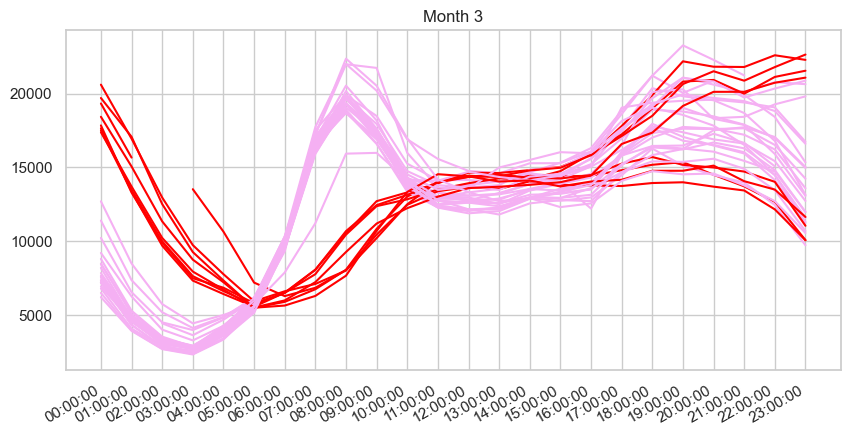

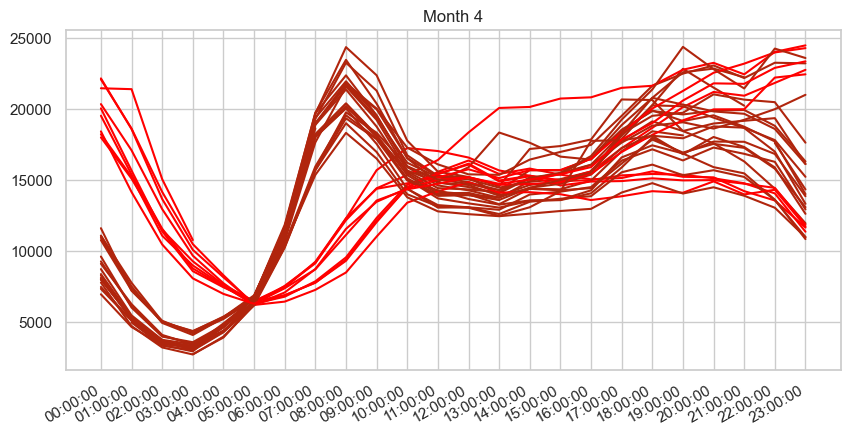

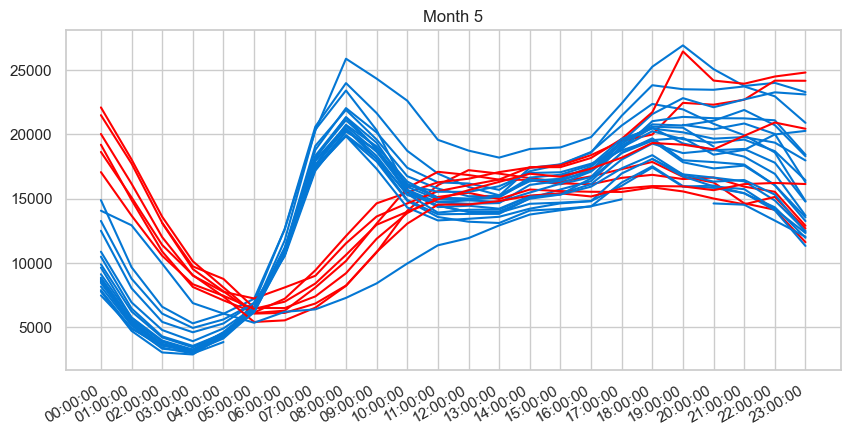

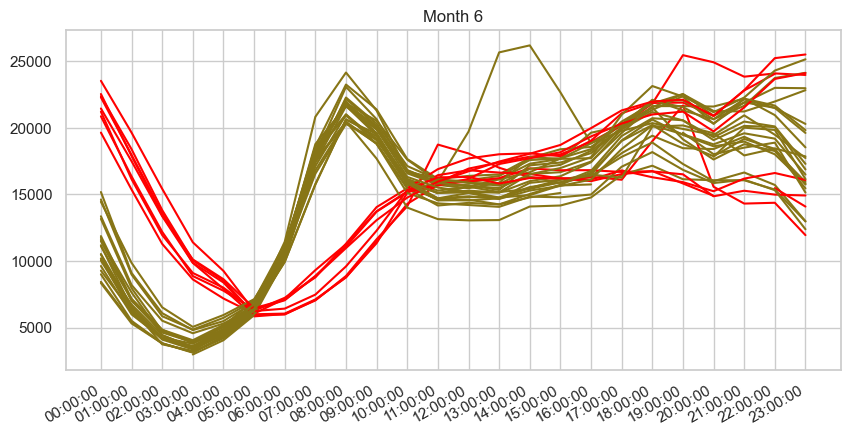

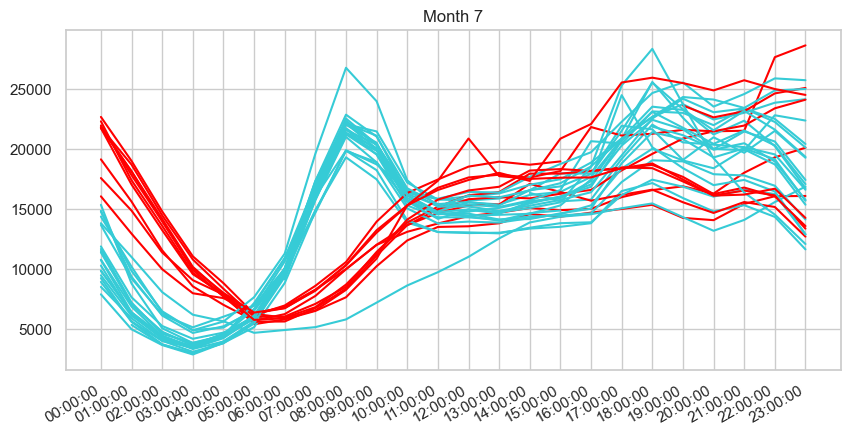

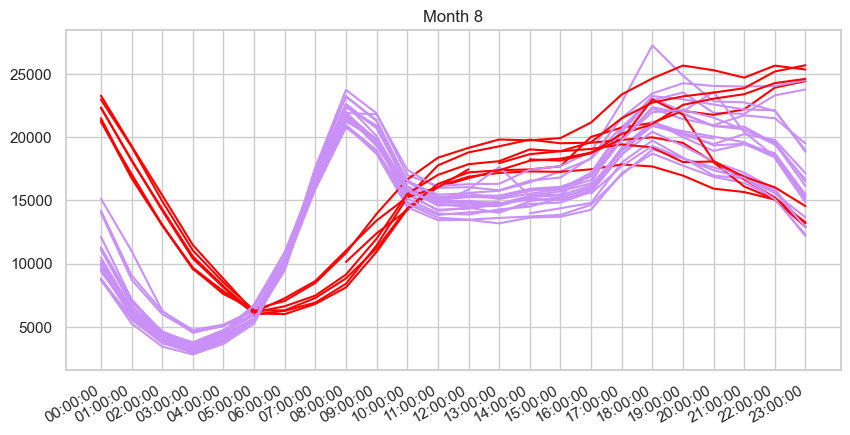

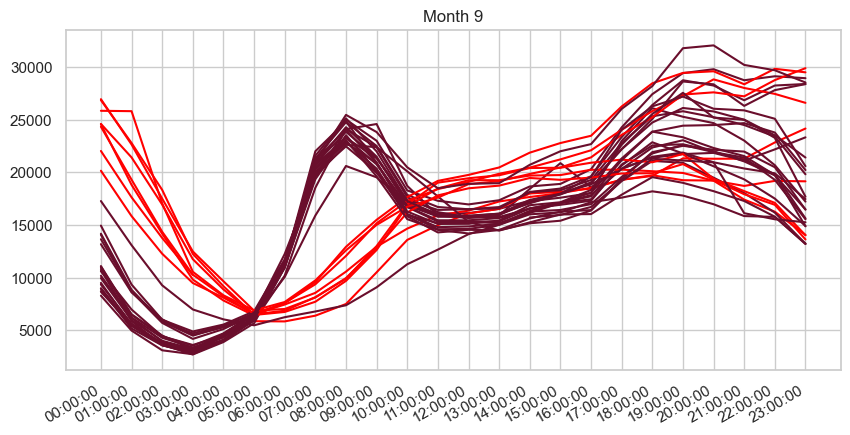

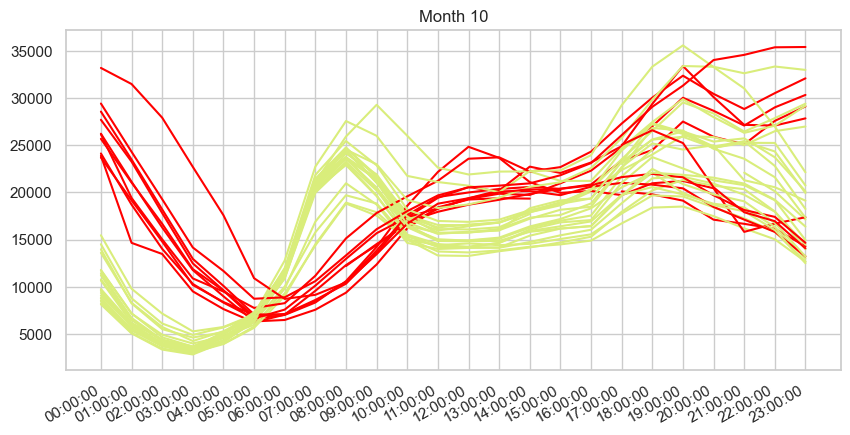

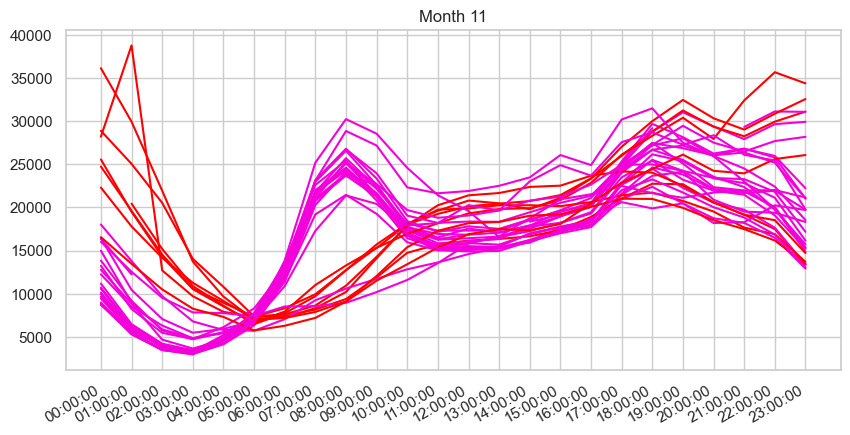

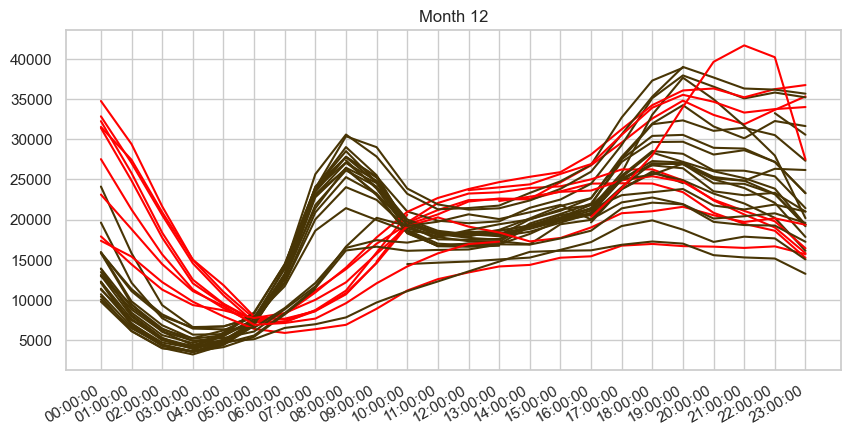

In [118]:
sns.set(style='whitegrid',rc={'figure.figsize':(10,5)})
eda = working_df.copy()
eda['day_of_month'] = eda['datetime'].dt.day
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(12)]
for month,color_ in zip(eda['month'].unique(),colors):
    for day in eda[eda['month']==month]['day_of_month'].unique():
        day_trend = eda[(eda['month']==month)&(eda['day_of_month']==day)][['datetime','trip_count','weekend']]
        if day_trend['weekend'].values[0] == 1:
            color = 'red'
        else:
            color = color_
        day_trend['time'] = day_trend['datetime'].dt.time
        time_series = pd.DataFrame(pd.date_range("00:00", "23:00", freq="60min").time).rename(columns={0:'time'})
        time_series = time_series.merge(day_trend,on='time',how='outer')
        plt.plot(time_series['time'].astype(str),time_series['trip_count'],
                color = color, label=month)
        plt.gcf().autofmt_xdate()
    plt.title('Month {}'.format(month))
    plt.show()

We can see that for all months, there is a similar daily ride trends where from a relatively high demand at around midnight, it tapers off at dawn when people are going to their homes/sleeping, and goes back up in the morning during rush hour (7-9am) when people are going to their respective places of work. The ride demand becomes static (but still relatively high) during work hours from 10am to 4pm, then climbs back up when people are going out of their places of work or going home. 

It is also important to note that on the weekends the trend deviates from the usual work-home scenario. We can see that for these days, demand goes down from midnight to its lowest at 5/6 am, with no peak during rush hours but climbs steadily until late evening. 

It's also interesting to note that the days where the weekends ride trends deviate are more noticeable on some months, namely February to August. This suggests that the "going-out" habits of people are more consistent during this months compared to Holiday season (September to December) where people tend to go out more to socialize, even on weekdays.

Lastly, September to December sees a higher demand in rides compared to other months.

#### 2. What does ride-hailing demand look like at different days of the week?

## Part 5. Conclusion